# Tutorial on DER Hosting Capacity | <font color=red>Part 2</font>: Time-Series Analysis and PV Hosting Capacity of LV Networks

## 1. Introduction 

### Objectives 
The objectives of this tutorial are:
1. To familiarise with the process by which power engineers can carry out **time-series analyses and determine the PV Hosting Capacity of a given LV distribution network**. To achieve this, you will run multiple time-series power flows with different PV penetratration levels and assess when the resulting effects go beyond the capabilities of a given LV network.

2. To continue familiarising with **advanced tools** useful to run distribution network studies involving DERs. You will continue using [OpenDSS](https://www.epri.com/pages/sa/opendss) via the [dss_python](https://github.com/dss-extensions/dss_python) module. And, to guide you, all will be done using a notebook on [Jupyter Notebook](https://jupyter.org/).

### Structure of this Notebook
The rest of this notebook is divided into three parts:

- **2. Tutorial.** 
    - You will learn, step by step, how to allocate time-varying **Load and PV profiles** to a given LV network with many customers at once. These profiles enable the **time-series analysis** necessary to observe how values (for instance, customer voltages) vary throughout the whole day due to PV (or any other technology).  
    - You will learn how to perform **PV Hosting Capacity** studies.
- **3. Exercises.** Here you will go through some exercises that will help you familiarise with the code and how to modify it for different purposes.
- **4. Simulation Workspace.** Here you can place all your code to run it at once. You should use **`code`** that is relevant to each exercise.

<font color='red'>**<u>Note</u>:**</font> Make sure to understand well how to model the network, particularly how to allocate PV systems and change PV penetrations (2. Tutorial) as this is crucial to go through the exercises. If you make a mistake when modelling the network, your results will be incorrect.

## 2. Tutorial
### 2.1 Test LV Circuit and Considerations
The test LV circuit (also known as feeder) used in this tutorial is a realistic, anonymised residential three-phase LV circuit based on data provided by **[AusNet Services](https://www.ausnetservices.com.au/)**, who is one of the distribution companies (known as Distribution Network Service Providers [DNSPs] in Australia) in the State of Victoria, Australia.

The time-series active power values of residential load and PV generation used in this tutorial correspond to real, anonymised measurements from smart meters and dedicated PV generation meters that were also provided by **[AusNet Services](https://www.ausnetservices.com.au/)**.

- The test LV circuit is one of multiple circuits connected to the same transformer (this is why its size is relatively large). For simplicity, only one LV circuit is being considered.

- Also note that although the nominal line-to-line voltage is 400V on the secondary of the transformer, the transformer is actually having a transformation ratio that *boosts* the voltage on the secondary (around 8%). This *boost* is common practice in Australia and other countries around the world. Of course, the off-load tap changes can be used to tune the transformation ratio as needed.

- The topology is shown in **Figure 1**. There are 31 single-phase residential customers connected through single-phase service cables. As shown in the figure, these customers are connected to different phase groups: 11 to phase 1 (red), 10 to phase 2 (black) and 10 to phase 3 (blue). A summary of characteristics of this LV circuit are provided in **Table 1**. 

- The residential load dataset contains profiles for 342 customers for a whole year (365 days) in 30-minute intervals. In this particular case, it contains only active power (kW). Consequently, in this tutorial we will be creating the associated reactive power (kvar) profiles.

- The residential PV generation dataset contains daily normalised (from 0 to 1) profiles for a whole year in 30-minute intervals. Given that the sun shines simultaneously to everyone in a small area (such as an LV circuit), for the day being investigated, only one PV generation profile is selected and applied for all the PV systems. However, the actual PV generation depends on the size of each of the PV systems (and any PV inverter function being used).

- Once specific days to be studied are defined, the code randomly allocates profiles of demand to customers. Similarly, once a PV penetration is defined (percentage of customers with a PV system), the code randomly allocates PV systems to customers. However, we use a `seed` to keep the same random list for different PV penetrations.

- Given that the Test LV Circuit has small impedances due to its modern design, **the adopted PV systems are large (with 10 kVA inverters). This is simply to demonstrate voltage rise issues**. However, in Australia, it is common for distribution companies to impose a 5kW export limit to single-phase customers. In practice, this means that most installations have inverters of up to 5kVA.

<img style="float: middle;" src="LVcircuit-topology.png" width="60%">

**<center>Figure 1. Test LV Circuit Topology</center>**

| Customers (1-ph) | LV Lines/Segments (3-ph) | Service Cables (1-ph) | Distribution Transformer (3-ph) | Frequency |
| :------: | :------: | :------: | :------: | :------: |
| 31 | 24 | 31 | 22/0.433 kV/kV, 500 kVA (D-Y) | 50 Hz |

**<center>Table 1. Summary of characteristics of the Test LV Circuit</center>**

### 2.2 Initialisation
#### 2.2.1 Import libraries
Run the code below to import the libraries that will be used in this tutorial.

In [27]:
import os
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import math
import dss
from random import choice

#### 2.2.2 Set the working path
Run the following code to set your working path.   
As an output you get the location in your computer.

In [28]:
mydir = os.getcwd()
print("The files are located in the following path: mydir = %s" %mydir)

The files are located in the following path: mydir = C:\Users\willi\Desktop\ELEN90077\WS2\Tutorial-DERHostingCapacity-2-TimeSeries_LV-main


#### 2.2.3 Set up  dss_engine
Before running the code, we need to set up the dss_engine.

In [29]:
dss_engine = dss.DSS
DSSText = dss_engine.Text                                                      
DSSCircuit = dss_engine.ActiveCircuit                                            
DSSSolution = dss_engine.ActiveCircuit.Solution                                      
ControlQueue = dss_engine.ActiveCircuit.CtrlQueue                                          
dss_engine.AllowForms = 0

### 2.3 Network, Load and DER Modelling
#### 2.3.1 Define components
**To simplyfy** our code, we can use **`Compile`** command to define a new circuit that is stored in `.txt` file, which in this case `LVcircuit-master.txt`. The `LVcircuit-master.txt` file defines the frequency and base voltages, then it **`Redirect`** to other `.txt` to define the network components: transformers, lines, loads, etc.

In [30]:
DSSText.Command = 'Clear'                               
DSSText.Command = 'Compile ' + mydir +  '\\LVcircuit-master.txt'    
DSSText.Command = 'Set VoltageBases = [22.0, 0.400]'
DSSText.Command = 'calcvoltagebases'

#### 2.3.2 Import Load and PV profiles
The datasets used in this tutorial are:

- `Residential load data 30-min resolution.npy`: This numpy file contains the load profiles (only active power) for 342 customers for a whole year in 30-minute intervals.
- `Residential PV data 30-min resolution.npy`: This numpy file contains normalised PV generation profiles for a whole year in 30-minute intervals.

In [31]:
houseData30minutes = np.load(mydir + '\\Residential load data 30-min resolution.npy') 
PVData30minutes = np.load(mydir + '\\Residential PV data 30-min resolution.npy')

In [32]:
# 导入季节PV数据
PVData_summer = np.load(mydir + '\\Residential_PV_profiles_Summer.npy')
PVData_autumn = np.load(mydir + '\\Residential_PV_profiles_Autumn.npy')
PVData_winter = np.load(mydir + '\\Residential_PV_profiles_Winter.npy')
PVData_spring = np.load(mydir + '\\Residential_PV_profiles_Spring.npy')

#### 2.3.3 Store the *shape* of the Load and PV profiles  
Now that the data has been loaded, let's take a look at the dimensions of the numpy files.  
**Note:** The format of the house data is `(Customers, Days, Readings)` stored in `shape_profiles` and the PV profiles' data is `(Days, Readings)` stored in `PV_shape_profiles` which can be seen by running the code below.

In [33]:
shape_profiles  = houseData30minutes.shape
noProfiles = shape_profiles[0]
PV_shape_profiles  = PVData30minutes.shape

print("The shape of the load profile is:", shape_profiles) 
print("The shape of the PV profiles is:", PV_shape_profiles) 

The shape of the load profile is: (342, 365, 48)
The shape of the PV profiles is: (365, 48)


#### 2.3.4 Visualise the Load profiles

**Note:** For simplicity, the Load profiles of all customers for *only one day* given as `selected_day` are plotted below. Since the profiles in this example correspond to Australian data (i.e., Southern Hemisphere), the start of the year (January) ccorresponds to summer (Jan-Feb), then autumn (Mar-May), winter (Jun-Aug), spring (Sep-Nov), and summer again (Dec).

Feel free to change the value of the `selected_day` to get different load profiles for different days of the year.

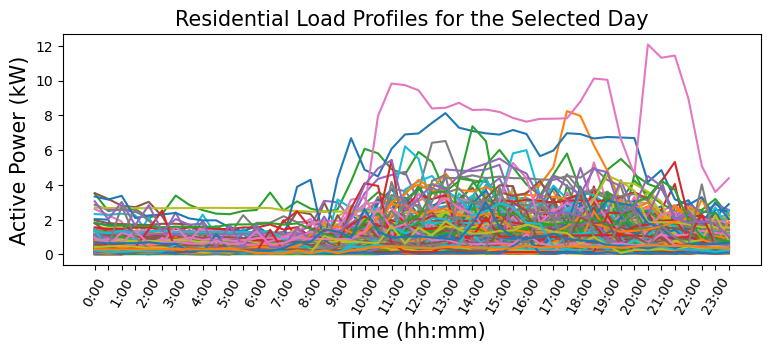

In [34]:
x=[i for i in range(48)]
l=[]
for i in range(24): 
      l.append("%s:00"%i)
      l.append(" ")
    
fig=plt.figure(figsize=(9,3)) 
selected_day=45                     #here is where you can change the selected day
for row in houseData30minutes[:,selected_day,:]:
   plt.plot(row, label = 'load profiles')
   plt.xlabel("Time (hh:mm)", fontsize = 15)
   plt.xticks(fontsize = 10)
   plt.xticks(x,l, fontsize=10, rotation=60)
   plt.ylabel('Active Power (kW)', fontsize = 15)
   plt.yticks(fontsize = 10)
   plt.title('Residential Load Profiles for the Selected Day', fontsize = 15)

#### 2.3.5 Visualise the normalised PV generation profiles
The plot of all normalised PV generation profiles for the whole year is shown by running the code below.

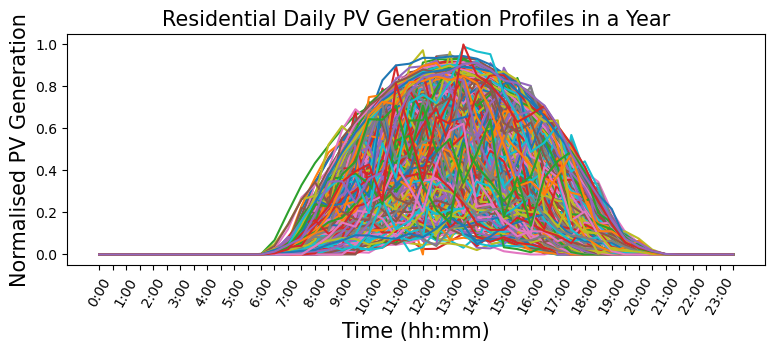

In [35]:
fig=plt.figure(figsize=(9,3)) 
for row in PVData30minutes:
   plt.plot(row, label = 'pv profiles')
   plt.xlabel("Time (hh:mm)", fontsize = 15)
   plt.xticks(fontsize = 10)
   plt.xticks(x,l, fontsize=10, rotation=60)
   plt.ylabel('Normalised PV Generation', fontsize = 15)
   plt.yticks(fontsize = 10)
   plt.title('Residential Daily PV Generation Profiles in a Year', fontsize = 15)

### 2.4 Definition of Functions
#### 2.4.1 def <font color=blue> Load_profile_allocation</font> (New,icust,cust,iday)
- When `New`==1, generate a new loadShape with empty `load_profile`. Set power factor equal to 0.95
- When `New`==0, set **LoadShapes** equal to random `load_profile` of `iday` from `houseData30minutes`. Allocate list `keep_power_factor` as powerfactor
- Allocate the loadshape **customer_profile_icust** to **load.cust**.

In [36]:
def Load_profile_allocation(New,icust,cust,iday):
    if New==1:
       load_profile = np.zeros(48)
       DSSCircuit.LoadShapes.New('customer_profile_%s' %(icust))
       DSSCircuit.LoadShapes.Npts = 48
       DSSCircuit.LoadShapes.MinInterval = 30
       DSSCircuit.LoadShapes.UseActual = 1
       DSSCircuit.LoadShapes.Qmult = (load_profile * math.tan(math.acos(0.95))).tolist()
    
    else:
        random_profile = np.random.randint(0,noProfiles)        
        load_profile = houseData30minutes[random_profile, iday, :]
        reactive_profile = []
        for j in range(48):
            reactive_profile.append((load_profile[j]) * math.tan(math.acos(keep_power_factor[icust][j])))
        reactive_profile = np.array(reactive_profile)          
        DSSCircuit.LoadShapes.Qmult = reactive_profile.tolist()
        
        
    DSSCircuit.LoadShapes.Name = 'customer_profile_%s' %(icust)
    DSSCircuit.LoadShapes.Pmult = load_profile.tolist()  
    DSSCircuit.SetActiveElement('load.%s'%(cust))
    DSSCircuit.ActiveElement.Properties('daily').Val = str('customer_profile_%s' %(icust))
    if New==0:
        return (load_profile,reactive_profile,random_profile)

#### 2.4.2 def <font color=blue> PV_allocation</font> (New, icust, cust, iday, curve_array)
- When `New`==1, generate a loadshape with name **pv_profile_icust** and allocate empty `PV_profile` to it. Generate **PVSystem.icust** and allocate it to **load.cust**. Allocate the loadshape **pv_profile_icust** to **PVSystem.icust**.
- When `New`==0, allocate `PV_profile` of `iday` to the loadshape **pv_profile_icust**. Allocate the loadshape **pv_profile_icust** to **PVSystem.icust**. Allocate **PVSystem.icust** to **load.cust**.

In [37]:
# def PV_allocation(New,icust,cust,iday,curve_array):
#     if New==1:
#         PV_profile = np.zeros(48)
#         DSSCircuit.LoadShapes.New('pv_profile_%s' %(icust))
#         DSSCircuit.LoadShapes.Npts = 48
#         DSSCircuit.LoadShapes.MinInterval = 30
#         DSSCircuit.LoadShapes.UseActual = 1
#         DSSCircuit.LoadShapes.Pmult = PV_profile.tolist()
#         DSSCircuit.SetActiveElement('load.%s' %(cust))
#         bus_name = DSSCircuit.ActiveElement.Properties('bus1').Val
#         DSSText.Command = 'new PVSystem.%s'%(icust)\
#                                 + ' phases = 1'  \
#                                 + ' irradiance = 1' \
#                                 + ' %cutin = 0.05' \
#                                 + ' %cutout = 0.05' \
#                                 + ' vmaxpu = 1.5' \
#                                 + ' vminpu = 0.5' \
#                                 + ' kva = 10' \
#                                 + ' pmpp = 10'\
#                                 + ' bus1 = ' + str(bus_name)\
#                                 + ' pf = 1' \
#                                 + ' kv = 0.23' \
#                                 + ' daily = ' +str('pv_profile_%s'%(icust))
#     else:
#         if len(curve_array.shape)==1:
#             PV_profile = curve_array
#         else:
#             PV_profile = curve_array[iday,:]
#         pv_profiles_all.append(PV_profile)        
#         DSSCircuit.LoadShapes.Name = 'pv_profile_%s' %(icust)
#         DSSCircuit.LoadShapes.Pmult = PV_profile.tolist()        
#         DSSCircuit.SetActiveElement('load.%s' %(cust))
#         bus_name = DSSCircuit.ActiveElement.Properties('bus1').Val
#         DSSCircuit.SetActiveElement('PVSystem.%s'%(icust))
#         DSSCircuit.ActiveElement.Properties('bus1').Val = str(bus_name)
#         DSSCircuit.ActiveElement.Properties('daily').Val = str('pv_profile_%s'%(icust))
#         return PV_profile

#### 2.4.3 def <font color=blue>Initiate_variable</font> (customers)
The variables used to monitor different values (as explained below), are firstly initialised as empty:
- `kW_monitors`, `df_kw` will restore single phase active power of load. 
- `kvar_monitors`, `df_kvar` will restore single phase reactive power of load. 
- `voltages_monitors`, `df_volt` will restore single phase voltage of load. 
- `pd.DataFrame()` is used to restore data to excel. 
- `load_profiles_all` will restore all the `load_ profile`. 
- `pv_profiles_all` will resotre all the `pv_profile`. 
- `random_profiles_all` will restore all `random_profile`.
- `rand_cust` restore all the `random_customer`.
- `reactive_profiles_all` restore all the `reactive_profile`.


In [38]:
def Initiate_variable(customers):
    kW_monitors = np.zeros((customers,48))
    kvar_monitors = np.zeros((customers,48))
    voltages_monitors = np.zeros((customers,48))
    df_kw = pd.DataFrame()
    df_kvar = pd.DataFrame()
    df_volt = pd.DataFrame()
    load_profiles_all = []
    pv_profiles_all = []
    random_profiles_all = []    
    rand_cust = []  
    reactive_profiles_all = []
    return  (kW_monitors, kvar_monitors, voltages_monitors, df_kw, df_kvar, 
             df_volt, load_profiles_all, pv_profiles_all, random_profiles_all, rand_cust,reactive_profiles_all)

#### 2.4.5 def <font color=blue>Monitors_data</font> ()

This function will be used to access and save active and reactive power as well as voltage magnitude of different load points. This is also a nice demonstration of accessing these measurements without the need of actually deploying monitors in our distribution network in OpenDSS.

In [39]:
def Monitors_data():
    for icust, cust in enumerate(Loadname):
            DSSCircuit.SetActiveElement('load.%s' %(cust))
            kW_monitors[icust, itime] = DSSCircuit.ActiveElement.Powers[0]
            kvar_monitors[icust,itime]= DSSCircuit.ActiveElement.Powers[1]
            bus_name = DSSCircuit.ActiveElement.Properties('bus1').Val
            DSSCircuit.SetActiveBus(bus_name)
            voltages_monitors[icust, itime] = DSSCircuit.ActiveBus.puVmagAngle[0]

## 2.5 Simulation and Results
### 2.5.1  Initialise Load profiles and PV systems
After defining the functions, we are ready to allocate the Load and PV profiles

In [40]:
Loadname = DSSCircuit.Loads.AllNames
for icust, cust in enumerate(Loadname):
    Load_profile_allocation(1,icust,cust,0)  
    PV_allocation(1,icust,cust,0, PVData30minutes)

### 2.5.2 Set simulation period
Set `start_day` and `total_day` to choose the simulation period you want.

In [41]:
start_day = 0
total_days = 3

### 2.5.3 Set PV penetration level
Here we choose the percentage of PV penetration (0-100%) we want to investigate.
- PV penetration is defined here as the percentage of houses with PV systems. Given that we have 31 residential customers, a 50% PV penetration means 15 customers.

In [42]:
penetration = 100
num_cust = len(Loadname)*(penetration/100)

### 2.5.4 Generate a random power factor list
Here a random power factor list is genereted a priori for each selected day (of the chosen `total days`) for all customers. This power factor will then be used to produce the associated reactive power profiles for each of the customers.

In [43]:
keep_power_factor = []
customers = len(Loadname)
for i in range(total_days*customers):
    keep_pf = []
    for j in range(48):
        random_pf = random.uniform(0.9,0.98)
        keep_pf.append(random_pf)
    keep_power_factor.append(keep_pf)

### 2.5.5 Daily power flow analysis 
A 30-min-resolution power flow analysis is executed for the chosen period and specified penetration level. For each daily simulation, the load profiles and PV systems are randomly allocated. 

**Note:** `random.seed()` helps to generate the same random list, so you can change the number in the bracket to make a new one. The same random list is needed for keeping the same customers when increasing the PV penetration level.

See steps as below:
1. Initiate all the variables as introduced in the function `Initiate_variable()`. 

2. Use `Load_profile_allocation()` function to allocate load profiles to all loads.
3. Restore all the load names in `random_customer`. Shuffle `random_customer`. Restore `random_customer[numb]` to `rand_cust`.
4. Use `PV_allocation()` fucntion to allocate **PVSystem.numb** to **load.random_customer[numb]**.
5. Set OpenDSS solution mode to daily.
6. Run the simulation and check convergence.
7. Retrieve the results from dss_engine and plot voltage profiles.

This is day:  0
Message: The Solution Converged Successfully



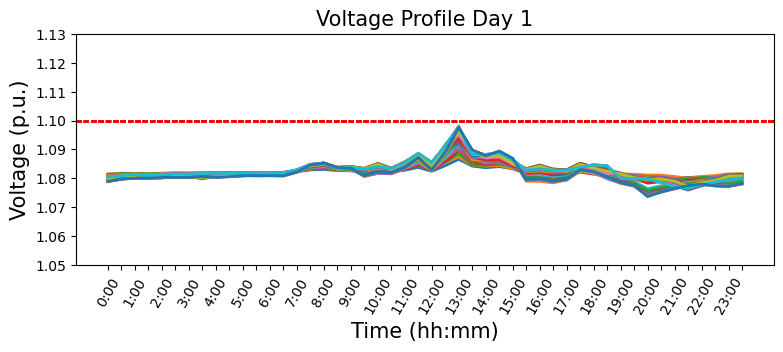

This is day:  1
Message: The Solution Converged Successfully



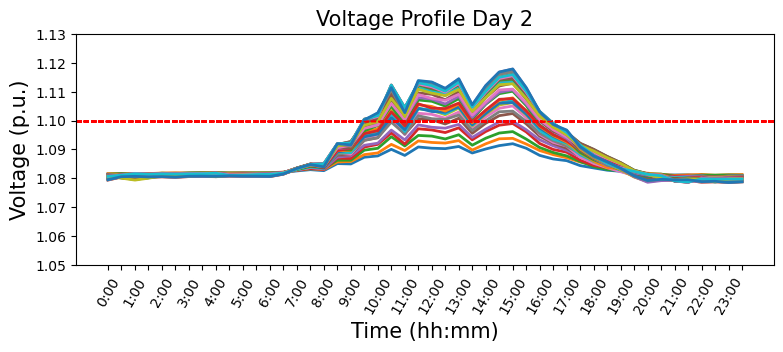

This is day:  2
Message: The Solution Converged Successfully



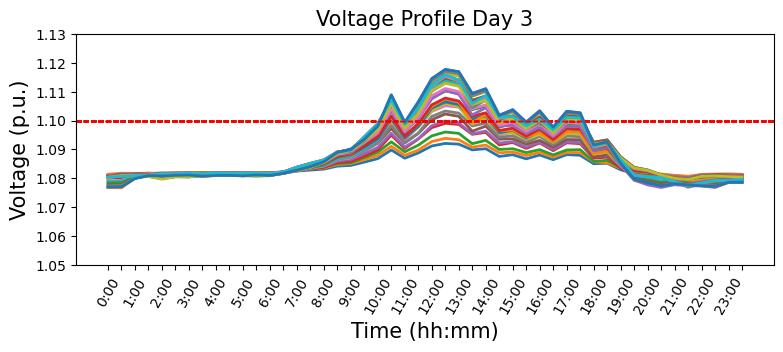

In [44]:
for iday in range(start_day,start_day+total_days):
    print("This is day: ",iday)
    np.random.seed(10)
    (kW_monitors, kvar_monitors, voltages_monitors, df_kw, df_kvar, df_volt, 
     load_profiles_all, pv_profiles_all, random_profiles_all, rand_cust,reactive_profiles_all) = Initiate_variable(customers)

    for icust, cust in enumerate(Loadname):
        load_profile,reactive_profile,random_profile=Load_profile_allocation(0,icust,cust,iday)
        load_profiles_all.append(load_profile)
        reactive_profiles_all.append(reactive_profile)
        random_profiles_all.append(random_profile)
        random.seed(90)
        
    random_customer = np.array(Loadname)
    random.shuffle(random_customer)    
    for numb in range(round(num_cust)):                
        rand_cust.append(choice([PV_cust for PV_cust in random_customer if PV_cust not in rand_cust]))
        PV_allocation(0,numb,rand_cust[numb],iday, PVData30minutes)
        PV_profile=PV_allocation(0,numb,rand_cust[numb],iday,PVData30minutes)
        pv_profiles_all.append(PV_profile)            
    DSSText.Command = 'Reset'       
    DSSText.Command = 'Set Mode=daily  number=1 stepsize=30m' 
        
    for itime in range(48):
        DSSSolution.Solve()
        Monitors_data()
    df_kw=pd.DataFrame(kW_monitors)
    df_kvar=pd.DataFrame(kvar_monitors)
    df_volt=pd.DataFrame(voltages_monitors)    
    
    if DSSSolution.Converged:
         print('Message: The Solution Converged Successfully\n')
    else:
         print("Message: The Solution Did Not Converge\n") 
    

        
    fig=plt.figure(figsize=(9,3)) 
    for idx, row in df_volt[0:31].iterrows():
             plt.plot(np.array(row), linewidth = 2)         
             plt.xlabel("Time (hh:mm)", fontsize = 15)
             plt.xticks(fontsize = 10)
             plt.xticks(x,l, fontsize=10, rotation=60)
             plt.ylabel('Voltage (p.u.)', fontsize = 15)
             plt.yticks(fontsize = 10)
             plt.title("Voltage Profile Day %s"%(iday+1), fontsize = 15)
             plt.ylim([1.05,1.13])
             plt.axhline(1.10, linewidth = 1,linestyle='dashed', color = 'r')
    plt.show()   

   

## 2.6 Further Analysis of the Results
### 2.6.1 Selected Load profiles & Customers allocated with **PV**

This section shows selected load profiles and customers which are allocated PV profiles. These are selected based on a random seed and then shuffled (**see section 4**) to include uncertainty in our analysis.

In [45]:
print("Load profiles in this seed: ",random_profiles_all,customers,'\n')     
print("The customers with allocated PV profiles are:" ,rand_cust,'\n')

Load profiles in this seed:  [265, 125, 15, 320, 123, 156, 221, 8, 73, 256, 40, 16, 239, 54, 122, 62, 33, 200, 177, 179, 54, 77, 13, 243, 141, 286, 158, 89, 140, 321, 31] 31 

The customers with allocated PV profiles are: ['load_mg1_13', 'load_mg1_14', 'load_mg1_24', 'load_mg1_27', 'load_mg1_3', 'load_mg1_31', 'load_mg1_20', 'load_mg1_4', 'load_mg1_23', 'load_mg1_15', 'load_mg1_5', 'load_mg1_11', 'load_mg1_8', 'load_mg1_29', 'load_mg1_9', 'load_mg1_18', 'load_mg1_22', 'load_mg1_30', 'load_mg1_7', 'load_mg1_10', 'load_mg1_12', 'load_mg1_19', 'load_mg1_17', 'load_mg1_16', 'load_mg1_6', 'load_mg1_26', 'load_mg1_28', 'load_mg1_25', 'load_mg1_1', 'load_mg1_21', 'load_mg1_2'] 



### 2.6.2 Verification of load curves

In this section, load curves are verified by plotting *actual load profile*, *monitored load* curves and *loadshapes* of **OpenDSS** loads. Actually, these are same load profiles but we want to verify if our code is using the same selected load profiles in **OpenDSS** simulation. For simplicity, only first load profile is verified.
If you want to check the load profile of other customer, change the `selected_customer` to another number (0 to 30).

In [46]:
# selected_customer=28
# fig=plt.figure(figsize=(9,3))
# plt.plot(load_profiles_all[selected_customer], label = 'actual')
# plt.plot(kW_monitors[selected_customer,:], label = 'monitored', linestyle='-.')
# DSSCircuit.LoadShapes.Name = 'customer_profile_%s' %(selected_customer)
# plt.plot(DSSCircuit.LoadShapes.Pmult, label = 'loadshape_opendss', linestyle='dashed')
# plt.xticks(x,l, fontsize=10, rotation=60)
# plt.xlabel("Time (hh:mm)", fontsize = 15)
# plt.ylabel('Active Power (kW)', fontsize = 15)
# plt.title('Verification of Load Curves', fontsize = 15)
# plt.legend()
# plt.show()

### 2.6.3 Plot of selected PV profiles

This section plots **PV profiles** of the days that are being used in our simulation. 

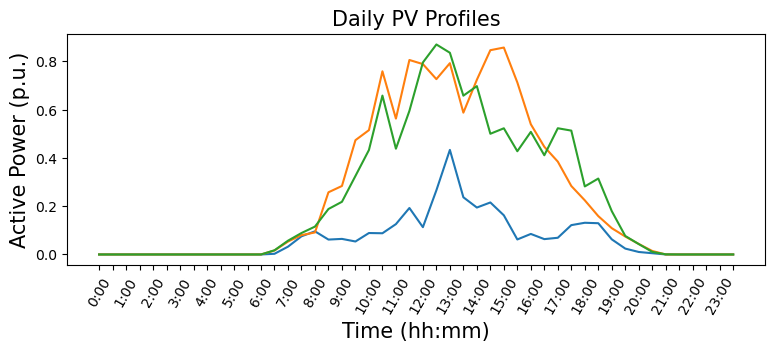

In [47]:
fig=plt.figure(figsize=(9,3))
plot_day=[i for i in range(start_day, total_days)]
for row in PVData30minutes[plot_day,:]:
   plt.plot(row, label = 'pv profiles')
   plt.xlabel("Time (hh:mm)", fontsize = 15)
   plt.xticks(fontsize = 10)
   plt.ylabel('Active Power (p.u.)', fontsize = 15)
   plt.xticks(x,l, fontsize=10, rotation=60)
   plt.yticks(fontsize = 10)
   plt.title('Daily PV Profiles', fontsize = 15)
plt.show()

## 3. Exercises

First, read all the exercises so you understand their purpose.

At the very end of this notebook in **4. Simulation Workspace**, you will be able to place all your code to run it at once. Remember, you should use **`code`** that is relevant to each exercise.

In [48]:
# 分析不同季节的最差情况PV曲线
# seasons = ['Summer', 'Autumn', 'Winter', 'Spring']
# worst_pv_profiles = []

# fig, axs = plt.subplots(2, 2, figsize=(12, 8))
# axs = axs.flatten()

# for i, season in enumerate(seasons):
#     pv_data = eval(f'PVData_{season.lower()}')
#     for j, profile in enumerate(pv_data):
#         axs[i].plot(profile, label=f'PV Profile {j}')
#     axs[i].set_title(f'{season} PV Profiles')
#     axs[i].set_xlabel('Time (30-min intervals)')
#     axs[i].set_ylabel('Normalized PV Generation')
#     axs[i].legend()

#     # 选择最差情况的PV曲线
#     worst_profile_index = int(input(f'Enter the worst-case PV profile index for {season}: '))
#     worst_pv_profiles.append(pv_data[worst_profile_index])

# plt.tight_layout()
# plt.show()


In [52]:
def PV_allocation(New, icust, cust, iday, season, pv_pen):
    if New == 1:
        PV_profile = np.zeros(48)
        DSSCircuit.LoadShapes.New('pv_profile_%s' % (icust))
        DSSCircuit.LoadShapes.Npts = 48
        DSSCircuit.LoadShapes.MinInterval = 30
        DSSCircuit.LoadShapes.UseActual = 1
        DSSCircuit.LoadShapes.Pmult = PV_profile.tolist()
        DSSCircuit.SetActiveElement('load.%s' % (cust))
        bus_name = DSSCircuit.ActiveElement.Properties('bus1').Val
        DSSText.Command = 'new PVSystem.%s' % (icust) \
                          + ' phases = 1' \
                          + ' irradiance = 1' \
                          + ' %cutin = 0.05' \
                          + ' %cutout = 0.05' \
                          + ' vmaxpu = 1.5' \
                          + ' vminpu = 0.5' \
                          + ' kva = 10' \
                          + ' pmpp = 10' \
                          + ' bus1 = ' + str(bus_name) \
                          + ' pf = 1' \
                          + ' kv = 0.23' \
                          + ' daily = ' + str('pv_profile_%s' % (icust))
    else:
        # 根据季节和PV渗透率选择对应的最坏情况PV曲线
        if season == 'Summer':
            worst_pv_idx = 0
        elif season == 'Autumn':
            worst_pv_idx = 1
        elif season == 'Winter':
            worst_pv_idx = 0
        else:  # Spring
            worst_pv_idx = 2

        # 加载对应的PV数据
        if season == 'Summer':
            pv_data = PVData_summer
        elif season == 'Autumn':
            pv_data = PVData_autumn
        elif season == 'Winter':
            pv_data = PVData_winter
        else:
            pv_data = PVData_spring

        PV_profile = pv_data[worst_pv_idx]
        pv_profiles_all.append(PV_profile)
        DSSCircuit.LoadShapes.Name = 'pv_profile_%s' % (icust)
        DSSCircuit.LoadShapes.Pmult = PV_profile.tolist()
        DSSCircuit.SetActiveElement('load.%s' % (cust))
        bus_name = DSSCircuit.ActiveElement.Properties('bus1').Val
        DSSCircuit.SetActiveElement('PVSystem.%s' % (icust))
        DSSCircuit.ActiveElement.Properties('bus1').Val = str(bus_name)
        DSSCircuit.ActiveElement.Properties('daily').Val = str('pv_profile_%s' % (icust))
        return PV_profile
    
seasons = ['Summer', 'Autumn', 'Winter', 'Spring']
start_days = [6, 63, 188, 231]

results = []
for season, start_day in zip(seasons, start_days):
    row = [season]
    for pv_pen in range(0, 101, 20):
        print(f'Running {season} with {pv_pen}% PV penetration')
        num_cust = len(Loadname) * (pv_pen / 100)

        # 初始化变量
        (kW_monitors, kvar_monitors, voltages_monitors, df_kw, df_kvar,
         df_volt, load_profiles_all, pv_profiles_all, random_profiles_all, rand_cust, reactive_profiles_all) = Initiate_variable(
            customers)

        # 分配负载曲线
        for icust, cust in enumerate(Loadname):
            load_profile, reactive_profile, random_profile = Load_profile_allocation(0, icust, cust, start_day)
            load_profiles_all.append(load_profile)
            reactive_profiles_all.append(reactive_profile)
            random_profiles_all.append(random_profile)

        # 随机选择客户安装PV系统
        random_customer = np.array(Loadname)
        random.shuffle(random_customer)
        for numb in range(round(num_cust)):
            rand_cust.append(choice([PV_cust for PV_cust in random_customer if PV_cust not in rand_cust]))
            PV_allocation(0, numb, rand_cust[numb], start_day, season, pv_pen)

        # 运行模拟
        DSSText.Command = 'Reset'
        DSSText.Command = 'Set Mode=daily  number=1 stepsize=30m'

        for itime in range(48):
            DSSSolution.Solve()
            Monitors_data()
            df_kw=pd.DataFrame(kW_monitors)
            df_kvar=pd.DataFrame(kvar_monitors)
            df_volt=pd.DataFrame(voltages_monitors)    

        if DSSSolution.Converged:
            print('Message: The Solution Converged Successfully\n')
        else:
            print("Message: The Solution Did Not Converge\n")

        # 统计不合规电压客户数
        non_compliant = sum(voltages_monitors.max(axis=1) > 1.1)
        row.append(non_compliant)

    results.append(row)

# 输出结果到表格
columns = ['Season'] + [f'{pv_pen}%' for pv_pen in range(0, 101, 20)]
results_df = pd.DataFrame(results, columns=columns)
print(results_df)

Running Summer with 0% PV penetration
Message: The Solution Converged Successfully

Running Summer with 20% PV penetration
Message: The Solution Converged Successfully

Running Summer with 40% PV penetration
Message: The Solution Converged Successfully

Running Summer with 60% PV penetration
Message: The Solution Converged Successfully

Running Summer with 80% PV penetration
Message: The Solution Converged Successfully

Running Summer with 100% PV penetration
Message: The Solution Converged Successfully

Running Autumn with 0% PV penetration
Message: The Solution Converged Successfully

Running Autumn with 20% PV penetration
Message: The Solution Converged Successfully

Running Autumn with 40% PV penetration
Message: The Solution Converged Successfully

Running Autumn with 60% PV penetration
Message: The Solution Converged Successfully

Running Autumn with 80% PV penetration
Message: The Solution Converged Successfully

Running Autumn with 100% PV penetration
Message: The Solution Conv

### **Exercise: PV Hosting Capacity using the Test LV Circuit**

In this exercise, you will use the Test LV Circuit and assess the PV Hosting Capacity considering different seasons. To achieve this, you will also need to **modify the code** as specified in each part of the exercise.

**E.1:** Starting from 0% PV penetration, increase the penetration by 20%, up to 100% PV penetration for **each** of the specified days per season (see below) using a *worst-case scenario* PV profile of the corresponding season. For each PV penetration and season, quantify how many customers have voltages that are non-compliant.
   - **Summer Day: `start_day=21`**
   - **Autumn Day: `start_day=59`**
   - **Winter Day: `start_day=199`**
   - **Spring Day: `start_day=229`**

>- The simulation will be done only for the specified day (i.e., **`total_days=1`**).
>- This also means that the demand will be defined by selecting that day and the pre-defined random seed.
>- For each season, change the input of the `PVData30minutes` variable (the PV dataset) to be equal to the relevant PV dataset (`Residential_PV_profiles_Summer.npy`, `Residential_PV_profiles_Autumn.npy`, `Residential_PV_profiles_Winter.npy` or `Residential_PV_profiles_Spring.npy`). Each dataset contains 3 diffent PV profiles.
>- For each season, select the PV profile that represents the **worst-case scenario**, i.e., the one that will cause the **worst voltage issues**. 
>- Once you find the **worst-case scenario** per season and its respective index on the array, change **for each season** the last input variable in the `PV_allocation` function to be the selected array (e.g, `PV_allocation(New, icust, cust, iday, PVData30minutes[index, :])`).

**E.2:** For each PV penetration and season from E.1, extract the active (P) power and reactive (Q) power for all the three phases of the transformer. Compute the apparent power (|S|) in kVA and check the level of utilisation of the transformer assuming a rated capacity of 175kVA.

>- The code to extract transformer's active and reactive power is given with the following code block, where the values for the whole day are stored per phase in the corresponding variables: `tr_ap_phaseA`, `tr_ap_phaseB`, `tr_ap_phaseC` **for the active power**, and `tr_rp_phaseA`, `tr_rp_phaseB`, `tr_rp_phaseC` **for the reactive power**. 
>- Due to the nature of OpenDSS, we need to multiply the values with (-1), so that we can interpret the values in the correct way: `negative value = power flows to the transformer`, `positive values = power flows from the transforer to the customers`.


In [50]:
tr_ap_phaseA = []
tr_ap_phaseB = []
tr_ap_phaseC = []

tr_rp_phaseA = []
tr_rp_phaseB = []
tr_rp_phaseC = []

for itime in range(48):
    DSSSolution.Solve()
    Monitors_data()
    DSSCircuit.SetActiveElement('transformer.transformer_MG1_TR1')
    tr_ap_phaseA.append(DSSCircuit.ActiveElement.Powers[8]*(-1))
    tr_ap_phaseB.append(DSSCircuit.ActiveElement.Powers[10]*(-1))
    tr_ap_phaseC.append(DSSCircuit.ActiveElement.Powers[12]*(-1))
    
    tr_rp_phaseA.append(DSSCircuit.ActiveElement.Powers[9]*(-1))
    tr_rp_phaseB.append(DSSCircuit.ActiveElement.Powers[11]*(-1))
    tr_rp_phaseC.append(DSSCircuit.ActiveElement.Powers[13]*(-1))   


>- To plot **transformer's active power** use the following code block. Note that `ap` in `tr_ap_phaseA` is for the **active power**. In order to obtain the plots for the **reactive power**, you should use `rp`.

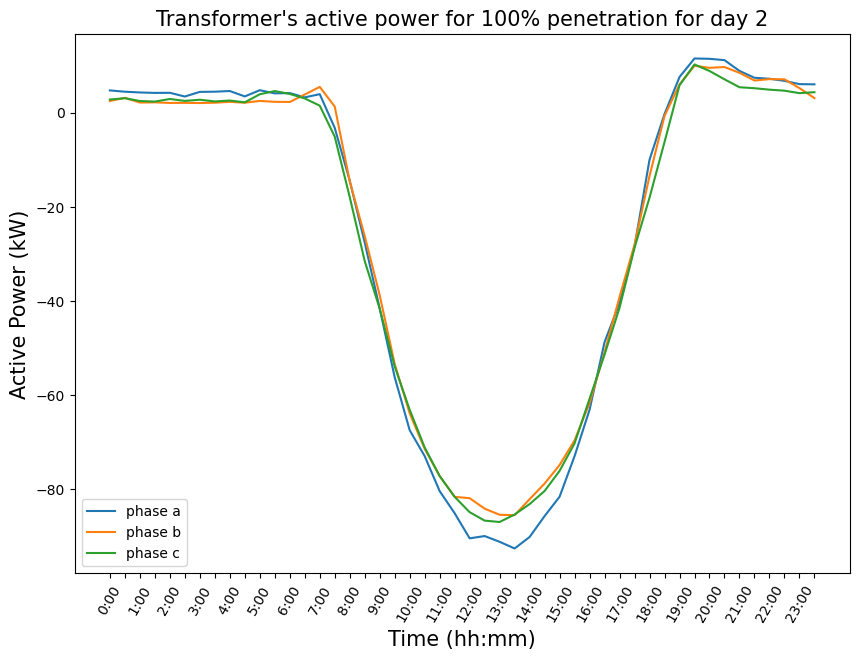

In [51]:
fig=plt.figure(figsize=(10,7))
plt.plot(tr_ap_phaseA, label='phase a')
plt.plot(tr_ap_phaseB, label='phase b')
plt.plot(tr_ap_phaseC, label='phase c')
plt.xlabel("Time (hh:mm)", fontsize = 15)
plt.xticks(fontsize=10)
plt.xticks(x,l, fontsize=10, rotation=60)
plt.ylabel('Active Power (kW)', fontsize=15)
plt.yticks(fontsize=10)
plt.title(f"Transformer's active power for {penetration}% penetration for day {iday}", fontsize=15)
plt.legend()

**E.3:** Based on the results obtained in E.1 and E.2, what is the PV Hosting Capacity?

## 4. Simulation Workspace